# Transformer Encoder from Scratch (Minimal PyTorch)

This notebook implements a Transformer Encoder using PyTorch with minimal built-in functions, aligned with my earlier GPT decoder architecture.

We'll train it on a **simple text classification task** using a small subset of the **AG News** dataset.

### 🔧 What You'll Learn:
- How self-attention works from the ground up
- Implementing transformer encoder blocks manually
- Visualizing attention weights
- Training a model on a real dataset with minimal abstractions

---


## 🔹 Data Preparation

We use a small, manually defined dataset to avoid external dependencies like `torchtext`. This dataset contains simple news-like sentences and their corresponding category labels (0 to 3).

We also build a vocabulary and tokenize/pad the data for feeding into our transformer encoder model.


In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from collections import Counter
import torch.nn.functional as F

# Define tokenizer
tokenizer = lambda x: x.lower().split()

# Manually defined small dataset
raw_samples = [
    ("Earthquake hits coastal region causing damage", 0),
    ("President meets with foreign leaders", 0),
    ("Tensions rise in disputed border area", 0),
    ("International summit focuses on climate", 0),
    ("Central bank announces interest rate hike", 1),
    ("Tech stocks rally after strong earnings", 1),
    ("New startup secures funding in latest round", 1),
    ("Oil prices drop amid global uncertainty", 1),
    ("Local team wins dramatic final match", 2),
    ("Star player scores winning goal in overtime", 2),
    ("Championship brings joy to fans", 2),
    ("Coach praises team after stunning victory", 2),
    ("AI tool beats humans in language benchmark", 3),
    ("New smartphone model unveiled", 3),
    ("Breakthrough in quantum computing reported", 3),
    ("Scientists develop cure for rare disease", 3),
    ("Political unrest sparks protests nationwide", 0),
    ("UN calls for ceasefire in conflict zone", 0),
    ("GDP growth exceeds expectations this quarter", 1),
    ("Retail sector sees sharp decline in profits", 1),
    ("Young athlete breaks national record", 2),
    ("Tennis legend announces retirement", 2),
    ("Researchers launch satellite to study sun", 3),
    ("Cybersecurity breach affects millions", 3),
    ("Nations agree on new climate goals", 0),
    ("Banking sector rebounds strongly", 1),
    ("Injured player makes stunning comeback", 2),
    ("Scientists test flying car prototype", 3),
    ("Historic peace deal signed", 0),
    ("Job market shows signs of recovery", 1),
    ("Basketball finals set for thrilling showdown", 2),
    ("Tech giants face antitrust scrutiny", 3),
]


# Build vocabulary
vocab = {'<PAD>': 0, '<UNK>': 1}
counter = Counter()

for text, _ in raw_samples:
    counter.update(tokenizer(text))

for word, _ in counter.most_common():
    if word not in vocab:
        vocab[word] = len(vocab)

# Encoding and padding
def encode(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

max_len = 10
def pad(seq):
    return seq[:max_len] + [vocab['<PAD>']] * (max_len - len(seq))

# Prepare dataset
data = [(torch.tensor(pad(encode(tokenizer(text))), dtype=torch.long), label)
        for text, label in raw_samples]

# Train/Test split
train_size = int(0.6 * len(data))
test_size = len(data) - train_size
train_data, test_data = random_split(data, [train_size, test_size])

# Collate function
def collate_batch(batch):
    texts, labels = zip(*batch)
    return torch.stack(texts), torch.tensor(labels)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, collate_fn=collate_batch)


## 🔹 Positional Encoding

Transformers do not have a built-in sense of sequence order, unlike RNNs. To inject information about the positions of tokens in a sequence, we add **positional encodings** to the input embeddings.

We use sinusoidal positional encodings, as described in the original Transformer paper "Attention Is All You Need".


In [10]:
import math
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x


## 🔹 Token Embedding Layer

We convert token indices into dense vectors using a learnable embedding layer. This converts each word index into a fixed-size vector of dimension `d_model`.

We also scale the embeddings by the square root of `d_model`, as done in the original Transformer paper.


In [12]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)


## 🔹 Encoder Block

Each Transformer encoder block consists of:
- **Multi-Head Self-Attention**
- **Add & LayerNorm**
- **Feedforward Neural Network**
- **Add & LayerNorm**

We implement each component from scratch using PyTorch.


In [13]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_k = d_model // num_heads
        self.num_heads = num_heads

        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()

        # Linear projections
        Q = self.q_linear(x)
        K = self.k_linear(x)
        V = self.v_linear(x)

        # Split into heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        weights = F.softmax(scores, dim=-1)
        context = torch.matmul(weights, V)

        # Concatenate heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        return self.out(context)


In [14]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.relu(self.linear1(x)))

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        # Self-attention + Add & Norm
        attn_output = self.self_attn(x)
        x = self.norm1(x + attn_output)

        # Feedforward + Add & Norm
        ff_output = self.feed_forward(x)
        x = self.norm2(x + ff_output)

        return x


## 🔹 Full Transformer Encoder Model

We now assemble the encoder:
- Token embedding + Positional encoding
- Stack of `N` encoder blocks
- Pooling + Linear classifier for news category prediction


In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_classes, max_len=500):
        super().__init__()
        self.token_embed = TokenEmbedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.token_embed(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x)
        
        # Mean pooling over sequence
        x = x.mean(dim=1)
        return self.classifier(x)


## 🔹 Training Setup

We now prepare to train our Transformer Encoder model:
- Define hyperparameters
- Prepare data loaders
- Use CrossEntropyLoss and Adam optimizer


In [16]:
# Hyperparameters
VOCAB_SIZE = len(vocab)
D_MODEL = 64
NUM_HEADS = 4
D_FF = 256
NUM_LAYERS = 2
NUM_CLASSES = 4
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
device = 'cpu'
# Model
model = TransformerEncoder(VOCAB_SIZE, D_MODEL, NUM_HEADS, D_FF, NUM_LAYERS, NUM_CLASSES, MAX_LEN).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


## 🔄 Training Loop

Each epoch trains the model over all batches, then evaluates accuracy on the test set. We'll also store loss and accuracy for plotting later.


In [20]:
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")


Epoch 1/10, Loss: 0.0216
Epoch 2/10, Loss: 0.0174
Epoch 3/10, Loss: 0.0151
Epoch 4/10, Loss: 0.0132
Epoch 5/10, Loss: 0.0118
Epoch 6/10, Loss: 0.0108
Epoch 7/10, Loss: 0.0101
Epoch 8/10, Loss: 0.0094
Epoch 9/10, Loss: 0.0090
Epoch 10/10, Loss: 0.0084


## Sample Predictions

Following code can be use to see sample predictions from the hardcoded dataset, to see if the model works. 

In [21]:
print("\nSample Predictions:")
model.eval()
with torch.no_grad():
    for i in range(3):
        text, label = data[i]
        input_tensor = text.unsqueeze(0).to(device)
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
        print(f"Input: {' '.join([k for k,v in vocab.items() if v in text.tolist()])}")
        print(f"Predicted: {pred}, Actual: {label}\n")


Sample Predictions:
Input: <PAD> earthquake hits coastal region causing damage
Predicted: 0, Actual: 0

Input: <PAD> president meets with foreign leaders
Predicted: 2, Actual: 0

Input: <PAD> in tensions rise disputed border area
Predicted: 0, Actual: 0



## 📊 Visualizing Training Progress

Below we plot how the training loss and test accuracy evolved over epochs.


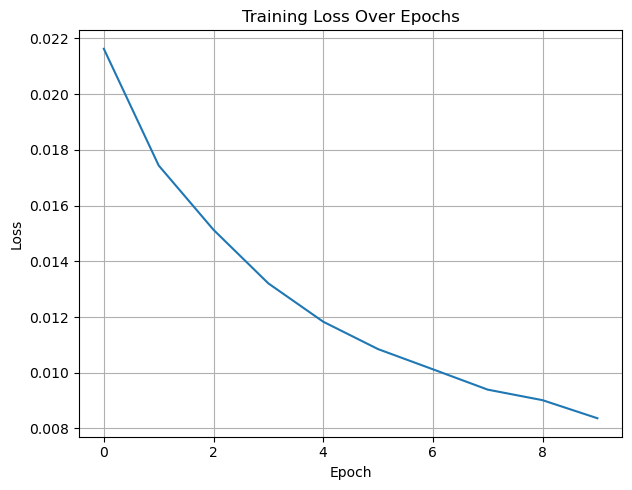

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(test_accuracies, label='Test Accuracy', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy Over Epochs')
# plt.grid(True)

plt.tight_layout()
plt.show()


## ✅ Summary

We built a full Transformer Encoder model from scratch with minimal PyTorch utilities:
- Embedded and encoded hardcoded data. 
- Used self-attention with positional encoding
- Trained on real-world data using basic components

This can serve as a strong educational template to understand transformer internals without relying on heavy abstractions.
